In [2]:
%load_ext autoreload
%autoreload 2

import torch
import text3d2video.wandb_util as wu
from text3d2video.artifacts.vertex_atributes_artifact import VertAttributesArtifact
from text3d2video.artifacts.animation_artifact import AnimationArtifact
from text3d2video.ipython_utils import display_ims

In [3]:
features_3d_artifact_tag = 'deadpool-3d-features:latest'
animation_tag = 'rumba:latest'

features_3d = wu.get_artifact(features_3d_artifact_tag)
features_3d = VertAttributesArtifact.from_wandb_artifact(features_3d)
mv_features = features_3d.get_mv_features_from_lineage()

animation = wu.get_artifact(animation_tag)
animation = AnimationArtifact.from_wandb_artifact(animation)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Downloading large artifact deadpool-3d-features:latest, 1375.15MB. 32 files... 
wandb:   32 of 32 files downloaded.  
Done. 0:0:0.5
wandb: Downloading large artifact deadpool-mv-features:v7, 592.93MB. 298 files... 
wandb:   298 of 298 files downloaded.  
Done. 0:0:1.0
wandb: Downloading large artifact rumba:latest, 121.09MB. 61 files... 
wandb:   61 of 61 files downloaded.  
Done. 0:0:0.4


In [4]:
from diffusers import ControlNetModel
from text3d2video.cross_frame_attn import CrossFrameAttnProcessor
from text3d2video.pipelines.my_pipeline import  MyPipeline

dtype = torch.float16
sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/sd-controlnet-depth"
device = torch.device('cuda')

controlnet = ControlNetModel.from_pretrained(
    controlnet_repo,
    torch_dtype=torch.float16
).to(device)

pipe = MyPipeline.from_pretrained(
    sd_repo,
    controlnet=controlnet,
    torch_dtype=dtype
).to(device)

Loading pipeline components...:  80%|████████  | 4/5 [00:00<00:00,  5.23it/s]/home/jorge/miniconda3/envs/thesis/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]


Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size 

100%|██████████| 31/31 [00:09<00:00,  3.20it/s]


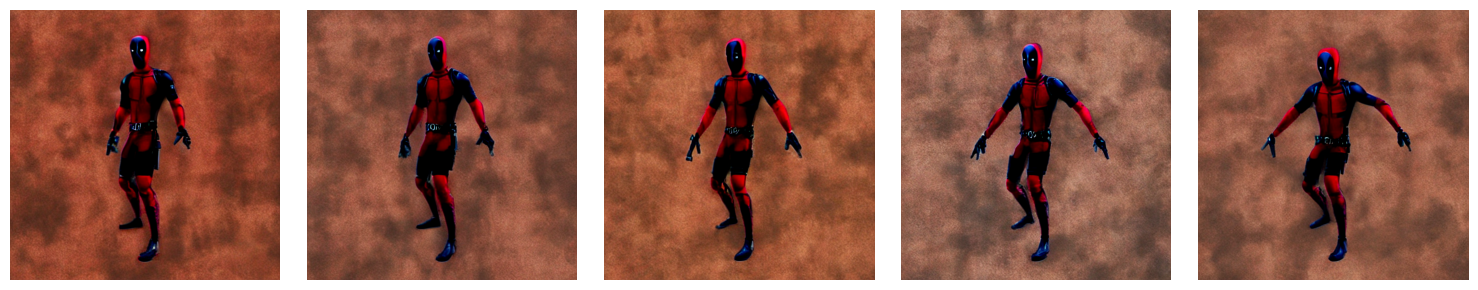

In [19]:
from scripts.generate_video import render_feature_images
from text3d2video.rendering import render_depth_map
from text3d2video.util import front_camera

frame_indices = [1,2,3,4,5]
do_feature_injection = True
num_steps = 30
prompt = 'Deadpool'
seed = 1

# render depth maps
camera = front_camera()
frames = animation.load_frames(frame_indices)
depth_maps = render_depth_map(frames, camera)

# render feature images
all_feature_images = render_feature_images(
    features_3d,
    mv_features,
    animation,
    frame_indices,
)

# Attention Processor setup
attn_processor = CrossFrameAttnProcessor(unet_chunk_size=2, unet=pipe.unet)
attn_processor.feature_images_multidict = all_feature_images
attn_processor.do_cross_frame_attn = do_feature_injection
pipe.unet.set_attn_processor(attn_processor)

# run pipeline
prompts = [prompt] * len(frame_indices)
generator = torch.Generator(device='cuda')
generator.manual_seed(seed)
images = pipe(prompts, depth_maps, generator=generator, num_inference_steps=num_steps)

display_ims(images, scale=3)

In [29]:
from text3d2video.ipython_utils import display_frames_as_video
from IPython.display import Video

mp4_path = display_frames_as_video(images)

Moviepy - Building video /tmp/tmp3oq1_i24.mp4.
Moviepy - Writing video /tmp/tmp3oq1_i24.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp3oq1_i24.mp4
